# SDGSat - Find Matching TIF-s

In [1]:
import geopandas as gpd
from dotenv import load_dotenv
from datetime import date

from conflict_monitoring_ntl.satellites import SDGSat
from geopandas.geodataframe import GeoDataFrame

In [2]:
_ = load_dotenv()

## Finding Matching TIF-s

In [3]:
gdf: GeoDataFrame = gpd.read_file("../data/shapes/lagos/lagos.shp")
date_range = [date(2024, 12, 22), date(2024, 12, 25)]

In [4]:
# gdf: GeoDataFrame = gpd.read_file("../data/shapes/zurich/zurich.shp")
# date_range = [datetime(2022, 3, 21), datetime(2022, 3, 23)]

In [5]:
sdgsat = SDGSat()
sdgsat_df = sdgsat.raster(gdf, date_range)

In [6]:
sdgsat_df

<xarray.Dataset> Size: 40MB
Dimensions:      (x: 3019, y: 2219, time: 3)
Coordinates:
  * x            (x) float64 24kB 5.953e+05 5.953e+05 ... 6.254e+05 6.255e+05
  * y            (y) float64 18kB 7.278e+05 7.278e+05 ... 7.056e+05 7.056e+05
  * time         (time) object 24B 2024-12-23 2024-12-24 2024-12-25
    spatial_ref  int64 8B 0
Data variables:
    HDR          (time, y, x) uint16 40MB 1 1 1 1 1 1 1 1 1 ... 0 0 0 0 0 0 0 0
Attributes:
    AREA_OR_POINT:             Area
    FOOTPRINT:                 POLYGON ((3.345000 6.223650, 4.740368 6.513707...
    STATISTICS_APPROXIMATE:    YES
    STATISTICS_MAXIMUM:        138
    STATISTICS_MEAN:           1.0048074929914
    STATISTICS_MINIMUM:        1
    STATISTICS_STDDEV:         0.24850477251119
    STATISTICS_VALID_PERCENT:  67.7
    _FillValue:                0
    scale_factor:              1.0
    add_offset:                0.0
    long_name:                 HDR

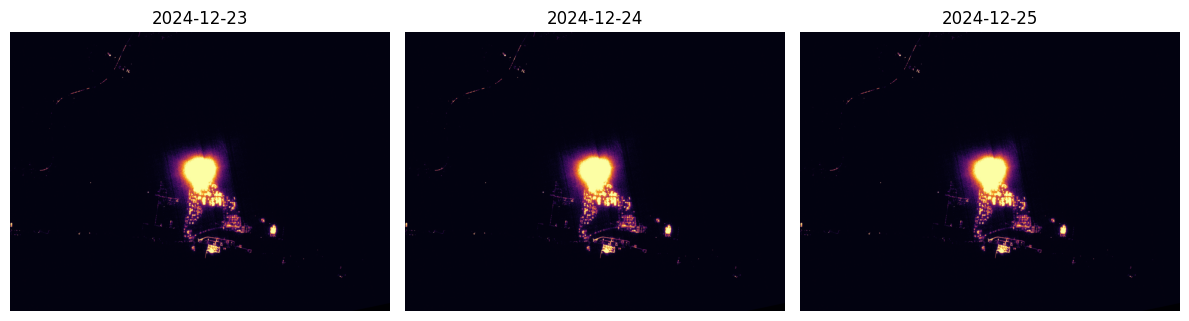

In [7]:
from conflict_monitoring_ntl.viz import plot_xarray_time_comparison


plot_xarray_time_comparison(sdgsat_df, "HDR")

In [12]:
sdgsat_patch = sdgsat_df["HDR"][0].to_numpy()

In [13]:
sdgsat_patch.shape

(2219, 3019)

(np.float64(-0.5), np.float64(3018.5), np.float64(2218.5), np.float64(-0.5))

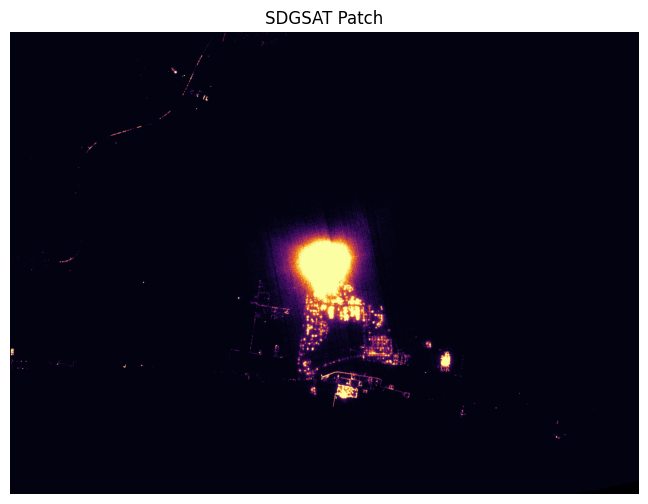

In [14]:
# Plot
from matplotlib import pyplot as plt
import numpy as np

fig, (ax1) = plt.subplots(1, 1, figsize=(14, 6))

valid_vals = sdgsat_patch[sdgsat_patch > 0]
vmax = np.percentile(valid_vals, 99) if valid_vals.size > 0 else 1

ax1.imshow(sdgsat_patch, cmap="inferno", vmin=0, vmax=vmax)
ax1.set_title("SDGSAT Patch")
ax1.axis("off")